In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, f_oneway, chi2_contingency

In [2]:
df_raw= pd.read_csv("food-prices-for-nigeria-2017-2021.csv")
df_raw.head()

,ItemLabels,Jan-17,Feb-17,Mar-17,Apr-17,May-17,Jun-17,Jul-17,Aug-17,Sep-17,...,Jun-21,Jul-21,Aug-21,Sep-21,Oct-21,Nov-21,Lowest,Highest,Month-on-Month,Year-on-Year
0,Agric eggs medium size,512.99,520.16,507.69,518.66,522.71,514.66,498.50,485.19,487.51,...,556.47,577.55,585.64,604.99,614.89,629.82,Borno (411.67),Bayelsa (800),2.43,27.31
1,Agric eggs(medium size price of one),47.42,42.90,43.93,46.22,45.73,45.28,44.32,42.92,45.72,...,51.22,52.73,53.20,54.62,55.49,57.35,Taraba (41.51),Ogun (70.06),3.35,28.15
2,"Beans brown,sold loose",353.60,337.11,353.28,357.19,365.86,374.26,382.35,370.25,404.84,...,471.24,485.44,496.03,492.13,478.76,490.19,Bauchi (234.29),Anambra (899.4),2.39,46.47
3,Beans:white black eye. sold loose,305.53,309.85,318.45,324.04,332.28,339.64,343.96,335.71,358.13,...,431.79,444.21,457.98,461.59,464.74,476.76,Bauchi (235.22),Ebonyi (887.77),2.59,54.61
4,Beef Bone in,1001.24,995.65,1010.29,1035.45,1123.65,1129.02,1128.94,1151.38,1078.49,...,1220.33,1262.10,1274.20,1320.73,1339.77,1366.24,Taraba (975.2),Abuja (1885.99),1.98,26.37


In [3]:
df_raw.info()
#observation => data is wide shaped: more features (columns) than explanations of those features(rows)
#we see lots of columns measure the same entity => date
#fix => reshape data to long form. 

#lowest, highest, month on month, year on year are all static values, and dont capture for the entire data,and thus cant really be used accurately
#fix => drop columns and re-engineer them later to capture accurately for each month/year

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 64 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ItemLabels      44 non-null     object 
 1   Jan-17          43 non-null     float64
 2   Feb-17          43 non-null     float64
 3   Mar-17          43 non-null     float64
 4   Apr-17          43 non-null     float64
 5   May-17          43 non-null     float64
 6   Jun-17          43 non-null     float64
 7   Jul-17          43 non-null     float64
 8   Aug-17          43 non-null     float64
 9   Sep-17          43 non-null     float64
 10  Oct-17          43 non-null     float64
 11  Nov-17          43 non-null     float64
 12  Dec-17          43 non-null     float64
 13  Jan-18          43 non-null     float64
 14  Feb-18          43 non-null     float64
 15  Mar-18          43 non-null     float64
 16  Apr-18          43 non-null     float64
 17  May-18          43 non-null     float

In [4]:
#create new df to hold cleaned dataset
df_clean = df_raw.copy()

# drop useless columns
df_clean = df_clean.drop(columns=["Month-on-Month","Year-on-Year","Lowest","Highest"],axis=1)

# Reshape: Melt wide to long
df_clean = df_clean.melt(
    id_vars='ItemLabels',
    var_name='Date',
    value_name='Price'
)

#view new shape
df_clean.head()

,ItemLabels,Date,Price
0,Agric eggs medium size,Jan-17,512.99
1,Agric eggs(medium size price of one),Jan-17,47.42
2,"Beans brown,sold loose",Jan-17,353.60
3,Beans:white black eye. sold loose,Jan-17,305.53
4,Beef Bone in,Jan-17,1001.24


In [5]:
#rename itemlabels to item. not neccessary, just my preference
df_clean = df_clean.rename(columns={"ItemLabels":"Item"})
df_clean.head()

,Item,Date,Price
0,Agric eggs medium size,Jan-17,512.99
1,Agric eggs(medium size price of one),Jan-17,47.42
2,"Beans brown,sold loose",Jan-17,353.60
3,Beans:white black eye. sold loose,Jan-17,305.53
4,Beef Bone in,Jan-17,1001.24


In [6]:
#check nulls
df_clean.isnull().sum()

Item      59
Date       0
Price    118
dtype: int64

In [7]:
#clean null columns

#drop nulls in item columns, as if there's no item, the row is useless since we're predicting prices of items
df_clean = df_clean.dropna(subset=["Item"])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2596 entries, 0 to 2654
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Item    2596 non-null   object 
 1   Date    2596 non-null   object 
 2   Price   2537 non-null   float64
dtypes: float64(1), object(2)
memory usage: 81.1+ KB


In [8]:
#check nulls in price
df_clean[df_clean['Price'].isnull()]
#footer text from data file makes up the nulls in price, so we drop them

df_clean = df_clean.dropna(subset=['Price'])
df_clean.info() #all rows are balanced now

<class 'pandas.core.frame.DataFrame'>
Index: 2537 entries, 0 to 2652
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Item    2537 non-null   object 
 1   Date    2537 non-null   object 
 2   Price   2537 non-null   float64
dtypes: float64(1), object(2)
memory usage: 79.3+ KB


In [9]:
# Convert date column to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format= '%b-%y')
df_clean.head()

,Item,Date,Price
0,Agric eggs medium size,2017-01-01,512.99
1,Agric eggs(medium size price of one),2017-01-01,47.42
2,"Beans brown,sold loose",2017-01-01,353.60
3,Beans:white black eye. sold loose,2017-01-01,305.53
4,Beef Bone in,2017-01-01,1001.24


In [10]:
#split date into month, year,quarter features. we dont split up to day as all days are on default(the first day of the month)
#we create this feature before the split because it doesnt look at target, and thus cant create leak. and we need it for further exploration
df_clean['Year'] = df_clean['Date'].dt.year
df_clean['Month'] = df_clean['Date'].dt.month
df_clean['Quarter'] = df_clean['Date'].dt.quarter
df_clean.head()

,Item,Date,Price,Year,Month,Quarter
0,Agric eggs medium size,2017-01-01,512.99,2017,1,1
1,Agric eggs(medium size price of one),2017-01-01,47.42,2017,1,1
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,1
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,1
4,Beef Bone in,2017-01-01,1001.24,2017,1,1


In [11]:
#for this model, we are working with only some selected staple foods

#view items
print(df_clean['Item'].unique())

#select staples
staples = ['Gari white,sold loose',
           'Gari yellow,sold loose',
           'Maize grain white sold loose', 
           'Maize grain yellow sold loose',
           'Rice agric sold loose',
           'Rice local sold loose',
           'Rice Medium Grained',
           'Rice,imported high quality sold loose',
           'Vegetable oil:1 bottle,specify bottle',
           'Yam tuber',
           'Beans brown,sold loose',
           'Beans:white black eye. sold loose',
           'Bread unsliced 500g',]

#filter by staples
df_staples = df_clean[ df_clean['Item'].isin(staples) ].copy()

['Agric eggs medium size' 'Agric eggs(medium size price of one)'
 'Beans brown,sold loose' 'Beans:white black eye. sold loose'
 'Beef Bone in' 'Beef,boneless' 'Bread sliced 500g' 'Bread unsliced 500g'
 'Broken Rice (Ofada)' 'Catfish (obokun) fresh' 'Catfish :dried'
 'Catfish Smoked' 'Chicken Feet' 'Chicken Wings' 'Dried Fish Sardine'
 'Evaporated tinned milk carnation 170g'
 'Evaporated tinned milk(peak), 170g' 'Frozen chicken'
 'Gari white,sold loose' 'Gari yellow,sold loose'
 'Groundnut oil: 1 bottle, specify bottle' 'Iced Sardine' 'Irish potato'
 'Mackerel : frozen' 'Maize grain white sold loose'
 'Maize grain yellow sold loose' 'Mudfish (aro) fresh' 'Mudfish : dried'
 'Onion bulb' 'Palm oil: 1 bottle,specify bottle' 'Plantain(ripe)'
 'Plantain(unripe)' 'Rice agric sold loose' 'Rice local sold loose'
 'Rice Medium Grained' 'Rice,imported high quality sold loose'
 'Sweet potato' 'Tilapia fish (epiya) fresh' 'Titus:frozen' 'Tomato'
 'Vegetable oil:1 bottle,specify bottle'
 'Wheat flou

In [12]:
#change item names to cleaner, easier to use and understand names => 'Bread unsliced 500g' = 'Bread
item_map = {'Gari white,sold loose': 'White Garri',
            'Gari yellow,sold loose': 'Yellow Garri',
            'Maize grain white sold loose': 'White Maize',
            'Maize grain yellow sold loose': 'Yellow Maize',
            'Rice agric sold loose': 'Agric Rice',
            'Rice local sold loose': 'Local Rice', 
            'Rice Medium Grained': 'Medium Grain Rice',
            'Rice,imported high quality sold loose': 'Imported Rice',
            'Vegetable oil:1 bottle,specify bottle': 'Vegetable oil',
            'Yam tuber': 'Yam',
            'Beans brown,sold loose': 'Brown Beans', 
            'Beans:white black eye. sold loose': 'White Beans',
            'Bread unsliced 500g': 'Bread',
}
#create a new column with the cleaned item names
df_staples['Item_Clean'] = df_staples['Item'].map(item_map)
df_staples.head()

,Item,Date,Price,Year,Month,Quarter,Item_Clean
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,1,Brown Beans
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,1,White Beans
7,Bread unsliced 500g,2017-01-01,270.25,2017,1,1,Bread
18,"Gari white,sold loose",2017-01-01,219.56,2017,1,1,White Garri
19,"Gari yellow,sold loose",2017-01-01,255.83,2017,1,1,Yellow Garri


In [13]:
df_staples.groupby('Item_Clean')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Item_Clean,,,,,,,,
Agric Rice,59.0,370.278814,53.919840,310.03,323.040,351.09,419.460,469.53
Bread,59.0,288.229661,23.540489,258.70,274.405,278.66,289.745,366.46
Brown Beans,59.0,367.621356,57.570427,267.81,327.030,368.98,396.035,496.03
Imported Rice,59.0,434.795593,75.034526,352.83,370.680,409.20,508.920,568.75
Local Rice,59.0,327.759492,51.212330,271.10,280.795,313.10,382.880,421.02
Medium Grain Rice,59.0,366.362034,55.761917,304.90,317.400,344.40,419.235,476.67
Vegetable oil,59.0,573.679322,89.724844,485.05,514.450,546.85,586.520,876.47
White Beans,59.0,333.726271,54.663086,241.74,296.185,332.28,356.180,476.76
White Garri,59.0,226.319322,56.027572,145.31,166.625,216.72,273.850,329.20


In [14]:
#create column with month names for easier understanding when exploring data

# Month name mapped directly from month number
month_map = {
    1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr",
    5: "May", 6: "Jun", 7: "Jul", 8: "Aug",
    9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"
}
df_staples.insert(df_staples.columns.get_loc('Month') + 1, 'Month_Name', df_staples['Month'].map(month_map))

# Force order directly on month names
df_staples['Month_Name'] = pd.Categorical(
    df_staples['Month_Name'],
    categories=["Jan","Feb","Mar","Apr","May","Jun",
                "Jul","Aug","Sep","Oct","Nov","Dec"],
    ordered=True
)

df_staples.head()

,Item,Date,Price,Year,Month,Month_Name,Quarter,Item_Clean
2,"Beans brown,sold loose",2017-01-01,353.60,2017,1,Jan,1,Brown Beans
3,Beans:white black eye. sold loose,2017-01-01,305.53,2017,1,Jan,1,White Beans
7,Bread unsliced 500g,2017-01-01,270.25,2017,1,Jan,1,Bread
18,"Gari white,sold loose",2017-01-01,219.56,2017,1,Jan,1,White Garri
19,"Gari yellow,sold loose",2017-01-01,255.83,2017,1,Jan,1,Yellow Garri


###  Exploring Quarter against price 
- **GOAL:** see which quarters have prices that are usally high vs usually low

- Q4 appeared as highest quarter 3 times (post-2018) and appeared as lowest quarter 2 times (pre-2019)

- Q1 most frequently occurred as the lowest quarter overall


- Planned flags: pre19_high_quarter, pre19_low_quarter, post18_high_quarter, post18_low_quarter.

    - If a quarter was highest in that year → mark 1 in corresponding _high column.

    - If lowest → mark 1 in corresponding _low column.


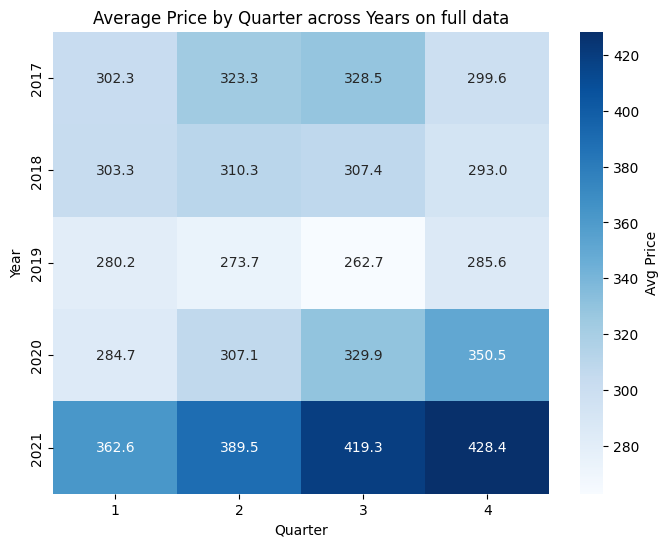

In [15]:
quarterly_avg = df_staples.groupby(['Year', 'Quarter'], as_index=False)['Price'].mean()

# Pivot for heatmap
pivot = quarterly_avg.pivot(index='Year', columns='Quarter', values='Price')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label':'Avg Price'})
plt.title("Average Price by Quarter across Years on full data")
plt.xlabel("Quarter")
plt.ylabel("Year")
plt.show()

In [16]:
# average price per year-quarter
df_year_quarter = df_staples.groupby(["Year", "Quarter"])["Price"].mean().reset_index()

# get idx of max and min quarter per year
yearly_quarter_extremes = (
    df_year_quarter.groupby("Year")
    .apply(lambda g: pd.Series({
        "high_quarter": g.loc[g["Price"].idxmax(), "Quarter"],
        "low_quarter": g.loc[g["Price"].idxmin(), "Quarter"],
    }))
    .reset_index()
)

print(yearly_quarter_extremes)


   Year  high_quarter  low_quarter
0  2017             3            4
1  2018             2            4
2  2019             4            3
3  2020             4            1
4  2021             4            1


In [17]:
high_counts = yearly_quarter_extremes["high_quarter"].value_counts().sort_index()
low_counts  = yearly_quarter_extremes["low_quarter"].value_counts().sort_index()

print("High quarter frequency:\n", high_counts)
print("Low quarter frequency:\n", low_counts)



High quarter frequency:
 high_quarter
2    1
3    1
4    3
Name: count, dtype: int64
Low quarter frequency:
 low_quarter
1    2
3    1
4    2
Name: count, dtype: int64


##### Steps to take based on observations:

- Drop pre-2019 data (since project goal is forward prediction).

- Perform quarterly analysis only on post-2018 data.

- Generate high/low quarter flags based solely on the relevant regime.

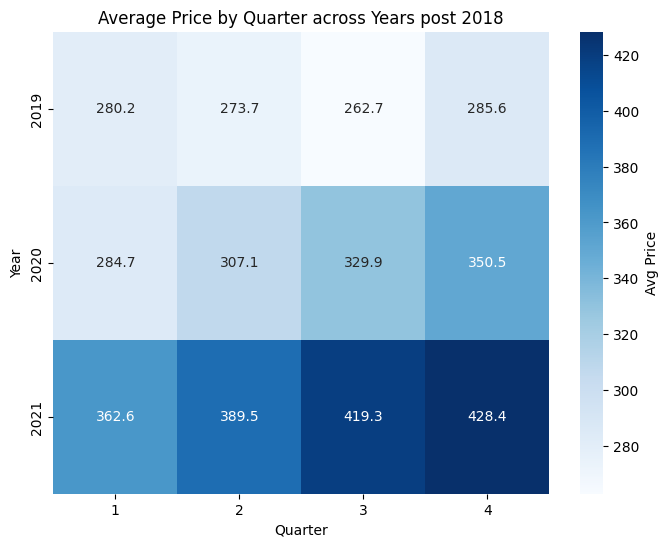

In [18]:
#create new df to hold post 2018 data
df_post18 = df_staples[ df_staples['Year'] > 2018 ].copy()

#visualize average price per quarter over years post 2018
quarterly_avg = df_post18.groupby(['Year', 'Quarter'], as_index=False)['Price'].mean()

# Pivot for heatmap
pivot = quarterly_avg.pivot(index='Year', columns='Quarter', values='Price')

plt.figure(figsize=(8,6))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="Blues", cbar_kws={'label':'Avg Price'})
plt.title("Average Price by Quarter across Years post 2018")
plt.xlabel("Quarter")
plt.ylabel("Year")
plt.show()

### Quarter Exploration Findings

**Observation:**

- post-2018 dataset covers only ~3 years. Within those, one year shows no clear pattern, breaking consistency.

**Implication:**

- Seasonal patterns (high/low quarters) are unstable.

- With such limited post-2018 data, the model cannot learn reliable seasonality.


**Decision:**

- Scrap deep feature extraction for quarters/months.

- Instead, use full data and a regime flag (pre2019 or post2018 to signal regime change).


### Items x Price Exploration
##### While quarter and month explorations were scrapped due to structural breaks post-2018, and limited years of data (making seasonal signals unreliable), item-level exploration remains valuable. Unlike seasonality, relative price levels across items are more stable over time i.e rice may generally cost more than beans, yam more than gari, etc. Exploring items helps us identify:

- which items are generally more expensive / cheaper
- if price change in one item influences price change in another
- item volatility/stability

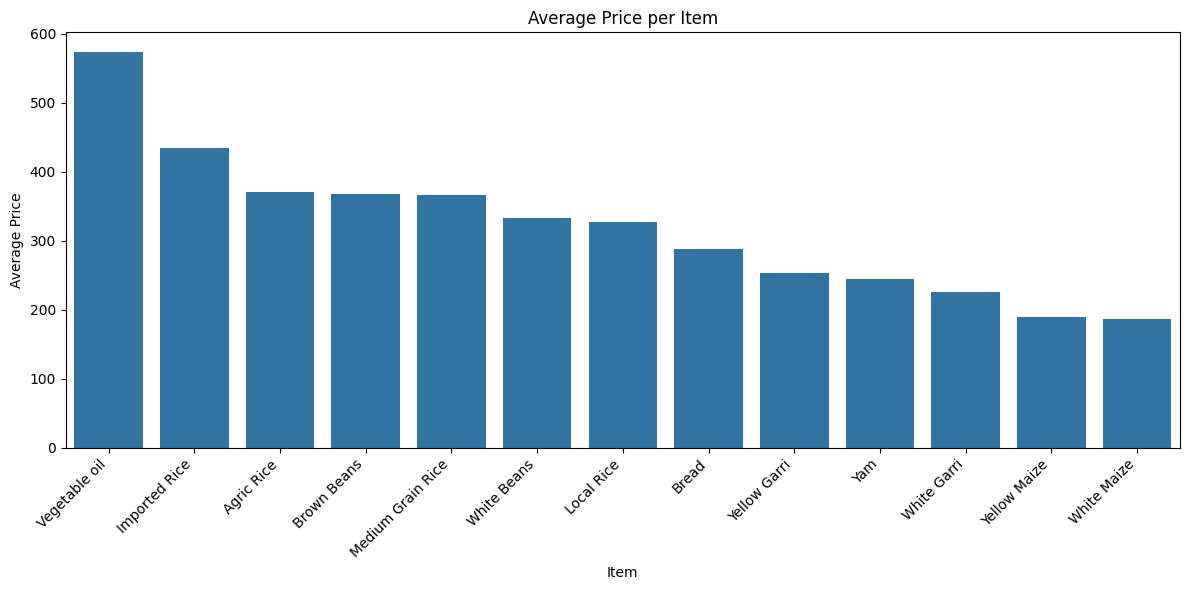

In [19]:
# Compute average price per item
avg_prices = df_staples.groupby('Item_Clean', as_index=False)['Price'].mean()

# Barplot
plt.figure(figsize=(12,6))
sns.barplot(data=avg_prices, x='Item_Clean', y='Price',
            order=avg_prices.sort_values('Price', ascending=False)['Item_Clean'])

# Rotate x labels
plt.xticks(rotation=45, ha='right')

# Titles and labels
plt.title("Average Price per Item")
plt.xlabel("Item")
plt.ylabel("Average Price")

plt.tight_layout()
plt.show()


##### Observation – Item-Level Price Differences

- From the average price plot across items:

- Consistently higher-priced items:

    - Vegetable oil sits at the top overall.
    - Among cereals/legumes, imported /Agric rice types and some bean varieties are also on the higher end.


- Consistently lower-priced items:

    - Maize, and white garri form the bottom cluster of cheaper staples, with yam being relatively low as well

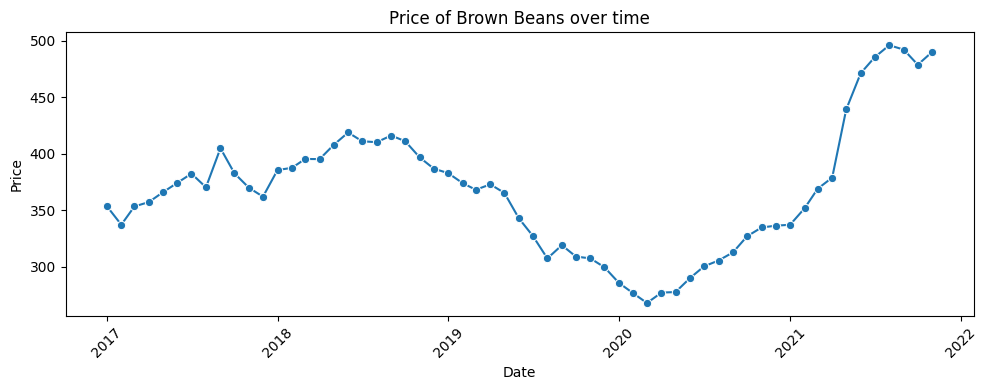

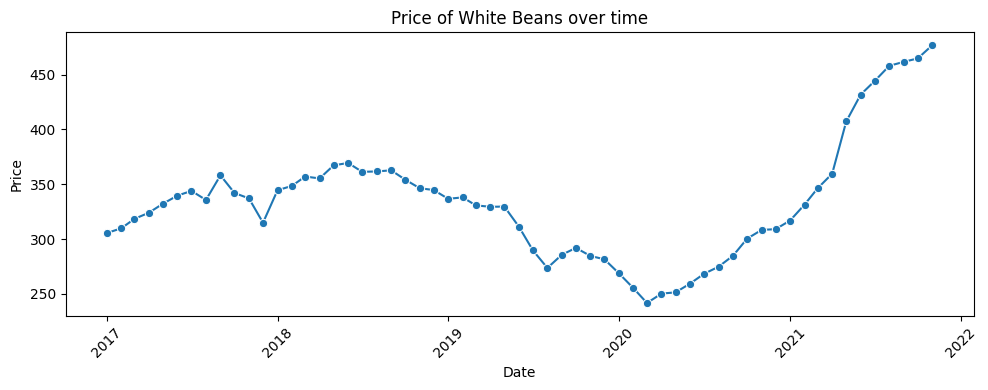

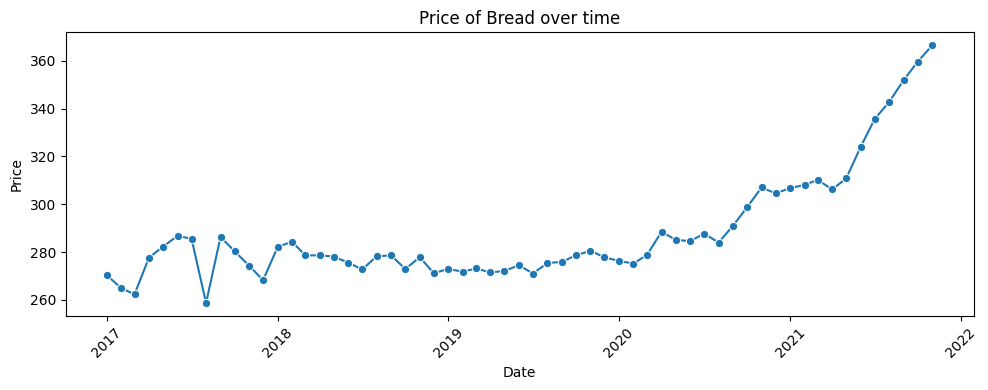

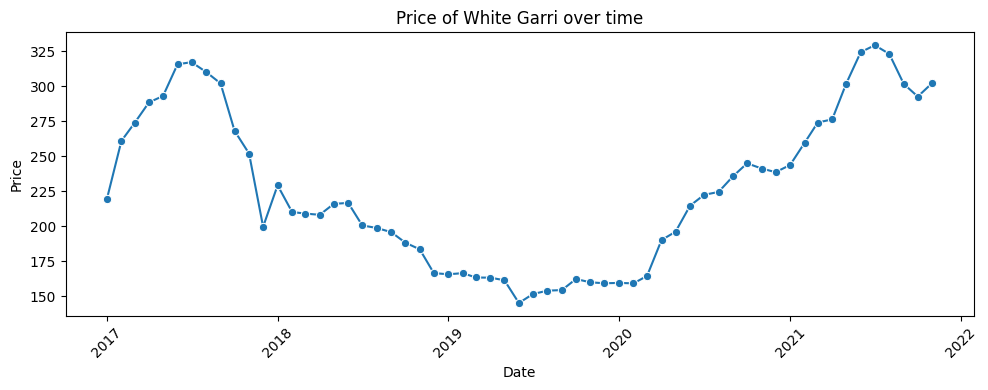

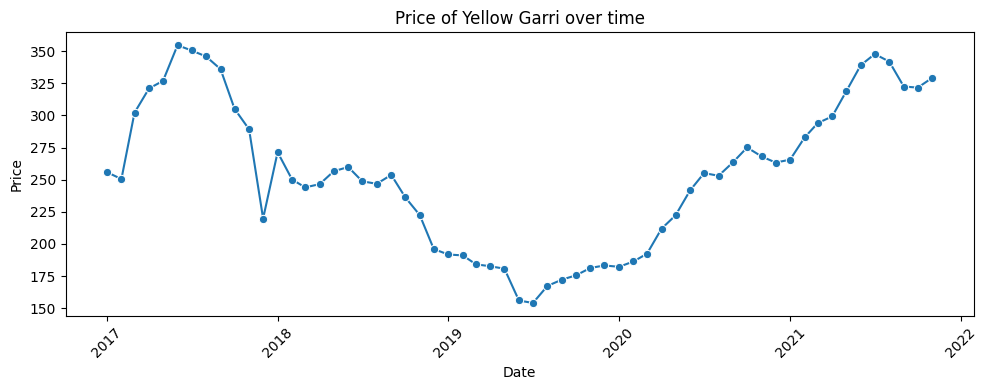

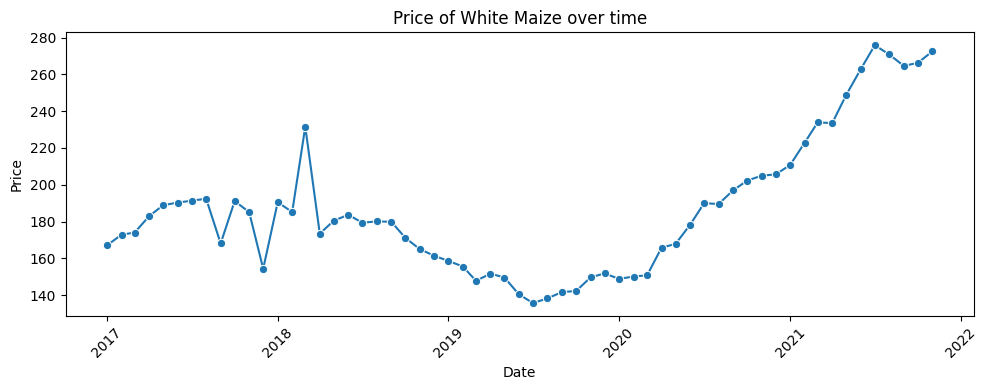

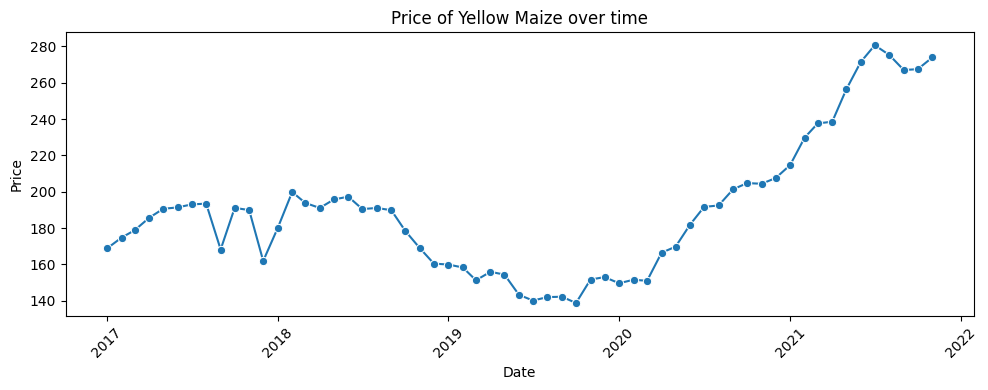

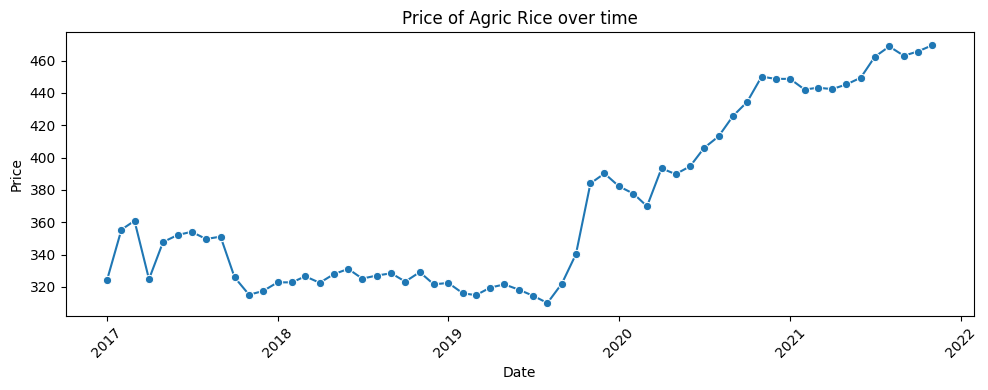

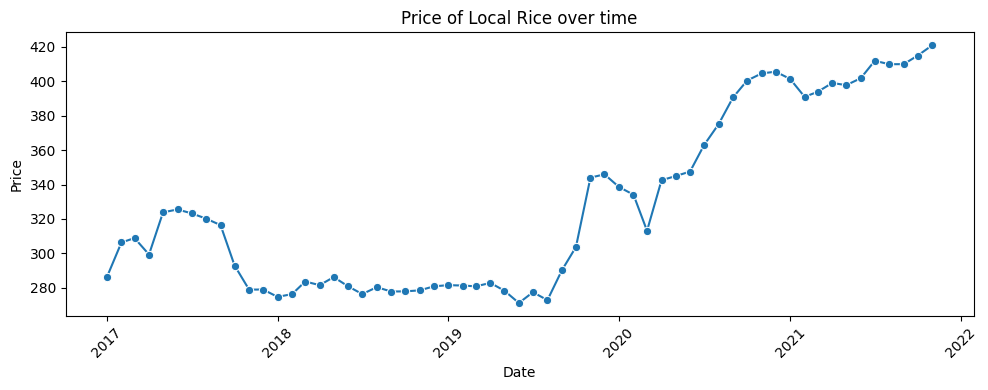

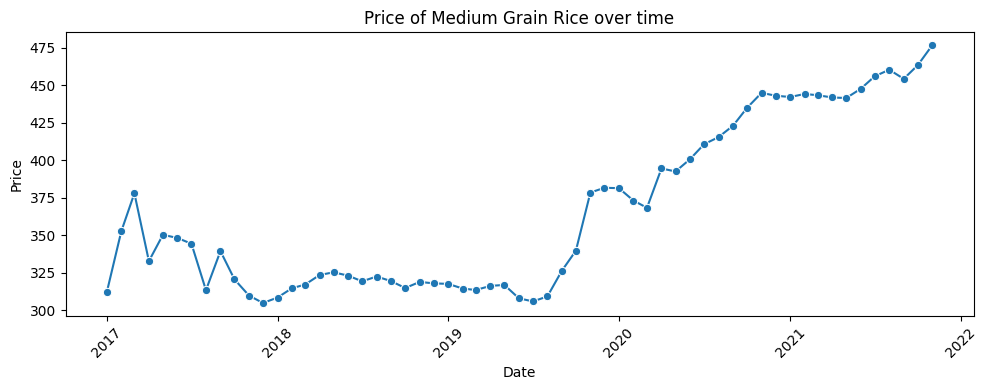

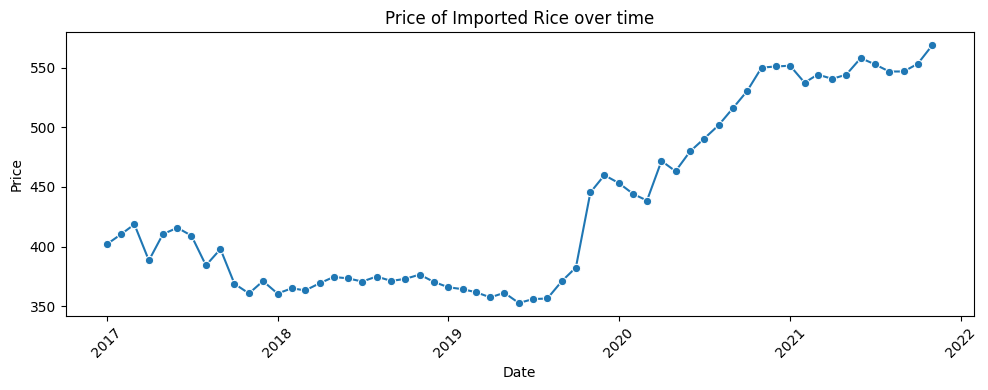

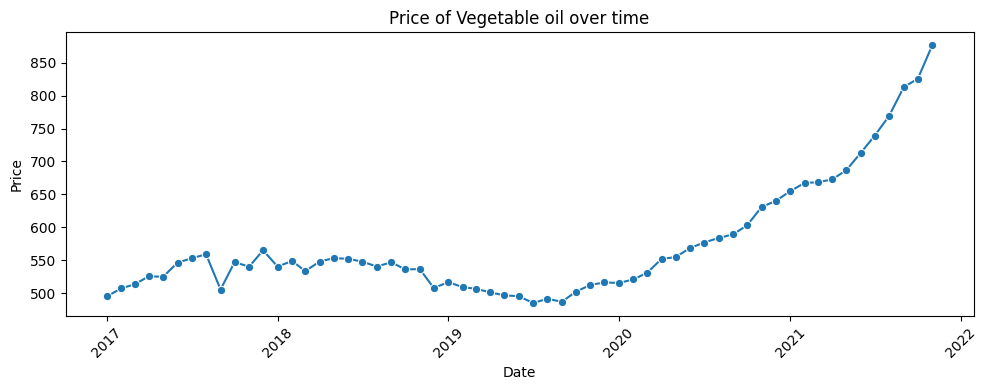

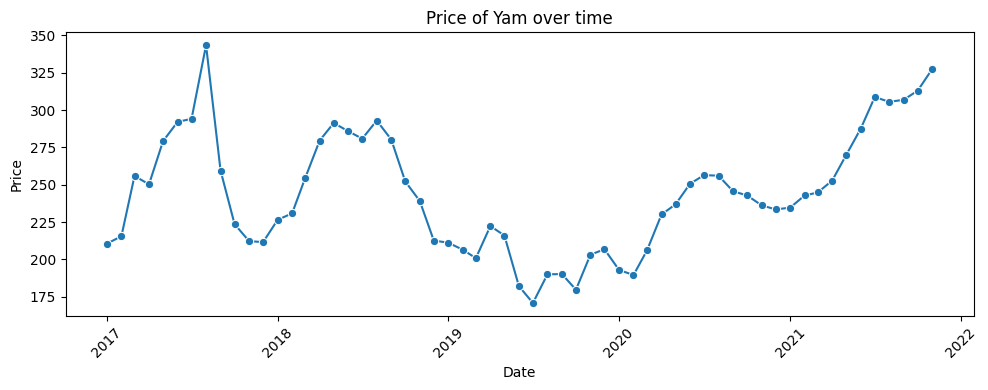

In [20]:
# Get unique items
items = df_staples['Item_Clean'].unique()

# Loop through each item and plot
for item in items:
    item_df = df_staples[df_staples['Item_Clean'] == item]
    
    plt.figure(figsize=(10,4))
    sns.lineplot(x='Date', y='Price', data=item_df, marker='o')
    
    plt.xticks(rotation=45)
    plt.title(f"Price of {item} over time")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.tight_layout()
    plt.show()


##### Observation – possible COVID-19 Price Spike (2020)

Around mid 2019 - 2021, most items experienced sharp upward price spikes.

Some items that were previously stable/declining rebounded sharply, reaching or surpassing their former highs, and continued to increase steadily post-2020.

In [22]:
#check items volatility

# Standard deviation per item
item_volatility = df_staples.groupby('Item_Clean')['Price'].std().reset_index()
item_volatility = item_volatility.rename(columns={'Price': 'Price_STD'})

#Coefficient of Variation (STD / Mean) for relative volatility
item_mean = df_staples.groupby('Item_Clean')['Price'].mean().reset_index()
item_mean = item_mean.rename(columns={'Price': 'Price_MEAN'})

item_volatility = item_volatility.merge(item_mean, on='Item_Clean')
item_volatility['Price_CV'] = item_volatility['Price_STD'] / item_volatility['Price_MEAN']

item_volatility.sort_values('Price_CV', ascending=False)


,Item_Clean,Price_STD,Price_MEAN,Price_CV
8,White Garri,56.027572,226.319322,0.247560
11,Yellow Garri,57.989180,253.992203,0.228311
9,White Maize,37.646570,186.738136,0.201601
12,Yellow Maize,37.888265,189.820847,0.199600
3,Imported Rice,75.034526,434.795593,0.172574
10,Yam,40.395294,244.511186,0.165208
7,White Beans,54.663086,333.726271,0.163796
2,Brown Beans,57.570427,367.621356,0.156603
6,Vegetable oil,89.724844,573.679322,0.156402
4,Local Rice,51.212330,327.759492,0.156250


**Observation:** Coefficient of variation across items is low (max 0.24), indicating that all staple prices are relatively stable in their movement.

In [23]:
#check items correlation
# Make a copy to be safe

df_corr = df_staples.copy()

pivot_df = df_corr.pivot_table(index='Date', columns='Item_Clean', values='Price')

# Compute correlations
corr_matrix = pivot_df.corr()

# Convert to long format for easier inspection
corr_long = (
    corr_matrix
    .reset_index()        # keep Item names in a column
    .melt(id_vars='Item_Clean', var_name='Item_2', value_name='Correlation')
    .rename(columns={'Item_Clean': 'Item_1'})
)

# Remove self-correlations
corr_long = corr_long[corr_long['Item_1'] != corr_long['Item_2']]

# Sort by absolute correlation
corr_long = corr_long.reindex(corr_long['Correlation'].abs().sort_values(ascending=False).index)

# Show top 10
corr_long.head(20)



,Item_1,Item_2,Correlation
3,Imported Rice,Agric Rice,0.992595
39,Agric Rice,Imported Rice,0.992595
5,Medium Grain Rice,Agric Rice,0.992082
65,Agric Rice,Medium Grain Rice,0.992082
44,Medium Grain Rice,Imported Rice,0.991001
68,Imported Rice,Medium Grain Rice,0.991001
4,Local Rice,Agric Rice,0.990507
52,Agric Rice,Local Rice,0.990507
43,Local Rice,Imported Rice,0.987715
55,Imported Rice,Local Rice,0.987715


In [24]:
# Remove duplicate and self-pairs
corr_unique = corr_long[corr_long['Item_1'] < corr_long['Item_2']]

# Categorize correlations
def corr_category(x):
    if x > 0.8:
        return 'High'
    elif x > 0.5:
        return 'Medium'
    else:
        return 'Low'

corr_unique['Category'] = corr_unique['Correlation'].apply(corr_category)

# Summary counts
corr_unique['Category'].value_counts()


C:\Users\user\AppData\Local\Temp\ipykernel_7072\1086569322.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_unique['Category'] = corr_unique['Correlation'].apply(corr_category)


Category
Medium    38
High      25
Low       15
Name: count, dtype: int64

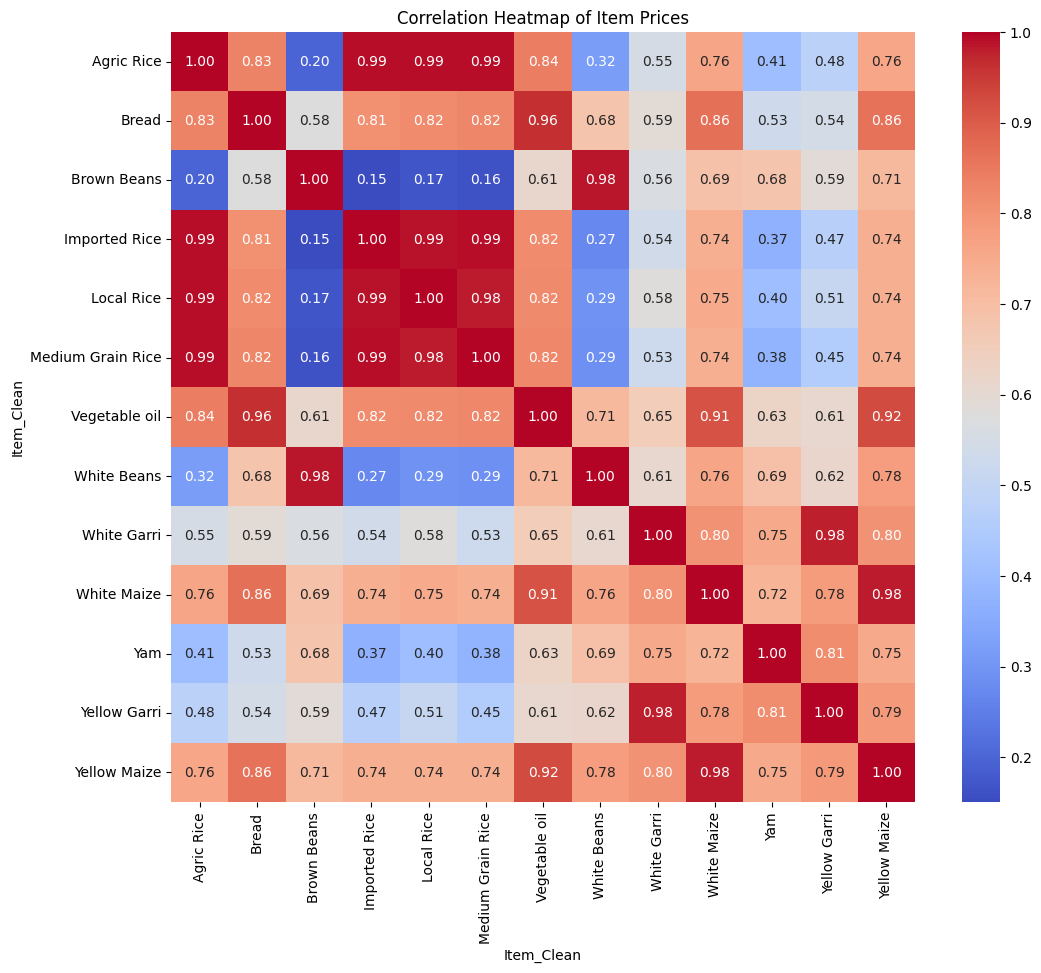

In [25]:
# Pivot to have items as columns
pivot_df = df_corr.pivot_table(index='Date', columns='Item_Clean', values='Price')

# Compute correlation matrix
corr = pivot_df.corr()

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Item Prices")
plt.show()


Observation: Yellow maize shows uniformly high correlations (≥0.71) with all items, making it a potential proxy for overall food market movements.
therefore a spike or drop in the price of yellow maize could signal price spike/drops in other stape foods.